In [32]:



import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Conv3D,Conv3DTranspose,Dropout,MaxPool3D,ZeroPadding3D,concatenate,Add,Dense,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

# my function/classes
#import model_classes as md
import usefull_functions as usf
import data_prep_functions as dpf
#import training_testing as tt

tf.keras.backend.clear_session()

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
#if os.path.abspath('.')=='/ShareData/emmweber/MachineLearning/predict_BH_dicoms':
strategy = tf.distribute.MirroredStrategy(devices=[ "GPU:1","GPU:0"])
#    print('OS = Ubuntu')

#    print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('GPU'))
    
# change path on window to only use a selected GPU
#elif os.path.abspath('.')=='D:\\emmweber\\Pycharm\\test':
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#print(tf.config.list_physical_devices('GPU'))
#    print("Windows device")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:0')
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
#with tf.device('/gpu:0,/gpu:1'):
#    print(tf.config.list_physical_devices('GPU'))

In [21]:

!pip install wandb -qqq
import wandb
#import model_classes_wandb as mdwb
from wandb.keras import WandbCallback

wandb.login()

import pickle

In [22]:
def train_gan_model(data_train_batch,data_test_batch,gen,disc,gan,config,i):
    
    g_loss_best=1e10
    tf.keras.backend.clear_session()
    
    for epochs in range(config.epoch):
        
        gen_loss=0
        for (X,y) in data_train_batch:
        
            
            batch_size=X.shape[0]
            # generate images ------------------------------------------
            fake_x = gen.predict(X)       
            real_x=y
            x=np.concatenate((real_x,fake_x))
                
            
            # discriminator -----------------------------------
            # half of the disc y to 0.9 to correlate with x       
            disc_y = np.zeros(2*batch_size)
            disc_y[:batch_size] = 1#0.9
        
            # train discriminator -----------------------------
            disc.trainable=True
            d_loss = disc.train_on_batch(x,disc_y)
            #d_loss_2 = disc.train_on_batch(x,disc_y)
            #GANlosses(gen_model=gen,x=X, y=y, disc_loss=d_loss)
            
            # train GAN -----------------------------------------
            y_gen = np.ones(batch_size)
            g_loss = gan.train_on_batch(X,y_gen)
            
            # check gen loss ----------------------------------
            new_fake_x = 
            gen_loss = gen_loss + mean_squared_error(real_x,fake_x)#np.mean(np.power((real_x-fake_x),2))
        
        
        print('epoch ' + str(epochs) + '/' + str(config.epoch) )
    
        # save current model
        #track=track_model(disc,gen,gan,output_dir+str(i))
        #track.calculate_total_loss(data_test_batch)
        #track.save_best_model()
        #if g_loss_best>g_loss: # save best training gan
        #track.save_other_models(track.model_gen,track.best_model_name_gen)
        #track.save_other_models(track.model_gan,track.best_model_name_gan)
        #track.save_other_models(track.model_disc,track.best_model_name_disc)
        #g_loss_best=g_loss
        
    
    
        ## TO DO -------------------------------------------------------------------------------------------
        
        # store losses in wandb ----------------
        # store:
        # epoch, g loss, d_loss, val loss
        wandb.log({"disc_loss_train":d_loss[0],
                   "disc_accuracy_train":d_loss[1],
                   "gan_loss_train":g_loss
                  })
                   
        
        #wandb.log({"train_loss_discriminator":d_loss[0],
        #           "train_accuracy_discriminator":d_loss[1],
        #           "train_loss_gan":g_loss,
        #           "val_loss_disc":track.validation_loss_disc_current,
        #           "val_accuracy_disc":track.validation_accuracy_disc,
        #           "val_loss_gen":track.validation_loss_gen_current, 
        #           "train_loss_gen":gen_loss
        #          })
    
    
    
    wandb.run.finish()

In [4]:
class track_model:
    def __init__(self,
                 model_disc,
                 model_gen,
                 model_gan,
                 save_path_model):
        
        
        self.save_path_model = save_path_model
        self.check_dir(save_path_model)
        
        # disc -----------------------------------------------------
        self.model_name_disc='disc'
        self.best_model_name_disc=save_path_model+'/'+self.model_name_disc+'_best_model'
        self.model_disc=model_disc
        
        # gen -----------------------------------------------------
        self.model_name_gen='gen'
        self.best_model_name_gen=save_path_model+'/'+self.model_name_gen+'_best_model'
        self.model_gen=model_gen
        
        # gen -----------------------------------------------------
        self.model_name_gan='gan'
        self.best_model_name_gan=save_path_model+'/'+self.model_name_gan+'_best_model'
        self.model_gan=model_gan
        
        # tracked loss ------------------------------------------
        self.validation_loss_disc_best=1e10
        self.validation_loss_disc_current=1e10
        self.validation_loss_gen_current = 1e10
        self.validation_accuracy_disc = 1e10
        
        self.validation_loss_total_current = 1e10
        self.validation_loss_total_best = 1e10
    
    # ------------------------------------------------------------------------
    def save_optimizer_weights(self,model,model_name):
        # save optimizer weights ------------------------------
        #model.save_weights('weights.h5')
        symbolic_weights = getattr(model.optimizer, 'weights')
        weight_values = tf.keras.backend.batch_get_value(symbolic_weights)
        with open(self.save_path_model+'/optimizer_'+ model_name+'.pkl', 'wb') as f:
                pickle.dump(weight_values, f)
        # how to load the optimizer weights:
        #model._make_train_function()
        # How to set weights to optimizer model
        #with open('optimizer.pkl', 'rb') as f:
        #    weight_values = pickle.load(f)
        #model.optimizer.set_weights(weight_values)
        

    # -------------------------------------------------------------------------    
    #def save_current_model(self):
    #    if not os.path.dirname(self.best_model_name):
    #        self.model.save(self.best_model_name)
            
     #   else:
     #       self.model.save(save_path_model+'/current_model')
    # -----------------------------------------------------------------------        
    def save_other_models(self,model,model_name):
        model.save(model_name)
        
    # ------------------------------------------------------------------------    
    def save_best_model(self):
        
        print('validation total = ' +str(self.validation_loss_total_current) )
            
        if self.validation_loss_total_current < self.validation_loss_total_best:
            # save gen
            self.model_gen.save(self.best_model_name_gen)
            self.validation_loss_gen_best=self.validation_loss_gen_current
            #self.save_optimizer_weights(self.model_gen,'gen')
            
            # save disc
            self.model_disc.save(self.best_model_name_disc)
            self.validation_loss_disc_best=self.validation_loss_disc_current
            self.save_optimizer_weights(self.model_disc,'disc')
            
            # save GAN
            self.model_disc.save(self.best_model_name_gan)
            self.validation_loss_total_best=self.validation_loss_total_current
            self.save_optimizer_weights(self.model_gan,'gan')
            
            print('save_models : ' + str(self.best_model_name_gen))
            
    #-------------------------------------------------------------------------    
    def calculate_validation_loss_gen(self,data_test_batch):
        
        
        for (X,y) in data_test_batch:
               current_images=self.model.predict(X)
            
            
            validation_loss=np.sum(np.power(y-current_images,2))/len(X)
            val_loss = val_loss+validation_loss
        
     #  self.validation_loss_gen_current=val_loss/len(data_test_batch)
        
        
    #----------------------------------------------------------------------- 
    #def calculate_validation_loss_disc(self,data_test_batch):
        
     #   for (X,y) in data_test_batch:
     #       fake_im=self.model_gen.predict(X)
     #       #validation_loss_data=sum(np.power(y-fake_im,2))/len(X)
            
     #       disc_pred= self.model_disc.predict(fake_im)
     #       bce= tf.keras.losses.binary_crossentropy()
     #       validation_loss_disc = bce(y,disc_pred)
            
     #       total_loss=validation_loss_data+validation_loss_disc
            
            
     #       val_loss = val_loss+total_loss
        
     #   self.validation_loss_disc_current=val_loss/len(data_test_batch)
    # ------------------------------------------------------------------------    
    def calculate_total_loss(self,data_test_batch):
        
        val_loss_gen=0
        val_loss_disc=0
        val_acc_disc=0
        #loss_gen = tf.keras.losses.mse
        loss_disc = tf.keras.losses.BinaryCrossentropy()
        
        for (X,y) in data_test_batch:
            
            batch_size=X.shape[0]
            
            # gen
            fake_im=self.model_gen.predict(X)
            
            validation_loss_gen = np.mean(np.power((y-fake_im),2))
            
            #validation_loss_gen=self.model_gen.evaluate(y,fake_im)
            
            val_loss_gen = val_loss_gen+validation_loss_gen
            
                      
            # disc
            im=np.concatenate((y,fake_im))           
            disc_y = np.zeros(2*batch_size)
            disc_y[:batch_size] = 0.9
            #disc_pred= self.model_disc.predict(im)
            
            
            output_disc = self.model_disc.test_on_batch(im,disc_y)#self.model_disc.evaluate(im,disc_y) #loss_disc(disc_y,disc_pred).numpy() ##
            validation_loss_disc=output_disc[0]
            val_accuracy_disc = output_disc[1]
            val_loss_disc = val_loss_disc + validation_loss_disc
            val_acc_disc = val_acc_disc + val_accuracy_disc
        
        self.validation_accuracy_disc = val_acc_disc/len(data_test_batch)  
        self.validation_loss_gen_current = val_loss_gen/len(data_test_batch)    
        self.validation_loss_disc_current = val_loss_disc/len(data_test_batch)    
        self.validation_loss_total_current=(val_loss_disc)/len(data_test_batch)
            
            


# ---------------------------------------------------------------------------

    def check_dir(self,name_dir):
        if not os.path.dirname(name_dir):
            os.makedirs(name_dir)

In [45]:
gen_model.summary()
    


Model: "model4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 256, 256, 12  378         ['input_1[0][0]']                
                                8, 3)                                                             
                                                                                                  
 activation (Activation)        (None, 256, 256, 12  0           ['conv3d[0][0]']                 
                                8, 3)                                                        

                                                                                                  
 dropout_2 (Dropout)            (None, 32, 32, 16,   0           ['max_pooling3d_2[0][0]']        
                                12)                                                               
                                                                                                  
 conv3d_9 (Conv3D)              (None, 32, 32, 16,   36024       ['dropout_2[0][0]']              
                                24)                                                               
                                                                                                  
 activation_9 (Activation)      (None, 32, 32, 16,   0           ['conv3d_9[0][0]']               
                                24)                                                               
                                                                                                  
 conv3d_10

                                12)                               'activation_18[0][0]']          
                                                                                                  
 conv3d_transpose_5 (Conv3DTran  (None, 64, 64, 32,   18012      ['add_6[0][0]']                  
 spose)                         12)                                                               
                                                                                                  
 activation_20 (Activation)     (None, 64, 64, 32,   0           ['conv3d_transpose_5[0][0]']     
                                12)                                                               
                                                                                                  
 dropout_5 (Dropout)            (None, 64, 64, 32,   0           ['activation_20[0][0]']          
                                12)                                                               
          

In [39]:
def create_disc_model(gen_model,  learning_rate,seed=123456, loss='binary_crossentropy', metrics=['accuracy'] ):
    # Note: do we want to pretrain the disc ?
    
    # extraction of encoder 
    model = Model(inputs = gen_model.layers[0].input, outputs = gen_model.get_layer('activation_9').output)#14').output)#gen_model.layers[44].output)

    # add layers ----------------------------------------------------------
    x=Flatten()(model.output)
    x=Dropout(0.5,name='dropout_init_new')(x)
    x=Dense(5,activation='relu',
               kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed),
                bias_initializer=tf.keras.initializers.Zeros())(x)

    x=Dense(1,activation='sigmoid')(x)
    disc_model = Model(inputs = gen_model.layers[0].input, outputs = x)
    
    # compile
    disc_opt=Adam(learning_rate=learning_rate, beta_1=0.9,decay = learning_rate )
    disc_model.compile(loss=loss, 
                       optimizer=disc_opt,
                       metrics=metrics)
    
    return disc_model, disc_opt

In [43]:
def create_GAN_model(X_train,gen_model,disc_model,epoch,learning_rate, loss='binary_crossentropy'):
    
    gan_input=Input(X_train.shape[1:])
    fake_image=gen_model(gan_input)
    gan_output=disc_model(fake_image)

    gan=Model(inputs=gan_input,outputs=gan_output)
    
    gan_opt = Adam(learning_rate=config.learning_rate/2, 
               beta_1=0.9, 
               decay=config.learning_rate/ config.epoch)

    gan.compile(loss=loss,optimizer=gan_opt)
    
    disc_model.trainable=True
    
    
    return gan, gan_opt

In [44]:
def save_models(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, 'gan')
    discriminator.trainable = True
    save_model(generator, 'generator')
    save_model(discriminator, 'discriminator')


In [42]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 128, 1  0         
                             )]                                  
                                                                 
 model4 (Functional)         (None, 256, 256, 128, 1)  585685    
                                                                 
 model_1 (Functional)        (None, 1)                 2061053   
                                                                 
Total params: 2,551,776
Trainable params: 2,551,776
Non-trainable params: 0
_________________________________________________________________


# Load data ----------------------------------------------

In [ ]:
seed=123456
np.random.seed(seed)


# load data -----------------------
data_X ='data/full_FB_low_high_14-May-2022.mat'#'data/full_FB_low_11012021.mat'  #'data/ADC_FB_high.mat' ##
data_Y ='data/full_BH_low_high_14-May-2022.mat'#'data/full_BH_low_11012021.mat'  #'data/ADC_BH_high.mat' ##
load = dpf.LoadData(path_data_x=data_X,
                    path_data_y=data_Y,
                    key_x='full_data',
                    key_y='full_data')


Xinit=load.Xinit
Yinit=load.Yinit



# Process data --------------------------------
prep = dpf.DataPreparation(x_init=Xinit,y_init=Yinit,option_save=True,
                           normalization=True,
                           slice_padding=True,
                          slice_padding_size=128)

X_train = prep.X_train
Y_train=prep.Y_train
X_test = prep.X_test
Y_test = prep.Y_test

val_size = int(0.15 * X_)


# create train, val and test set
full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
full_dataset = full_dataset.shuffle()
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)


# assign models directory (date)
output_dir = prep.dir_name + '/'


In [50]:
X_train.shape[0]*15/100

16.05

In [6]:
# check the key to use -------------
check_key=False
if check_key:
    import scipy.io as sio
    test=sio.loadmat(data_X)
    list(test.keys())[3]

## Find proper slice to compare and save

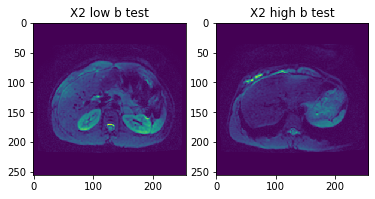

In [7]:
#Slices X2 test
slice_X2_low_test = 12
slice_X2_high_test = 30


plt.figure()

plt.subplot(1,2,1)
plt.title('X2 low b test')
plt.imshow(X_test[2,:,:,slice_X2_low_test,0])
plt.subplot(1,2,2)
plt.title('X2 high b test')
plt.imshow(X_test[2,:,:,slice_X2_high_test,0])

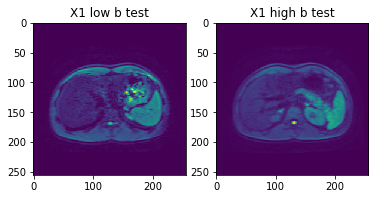

In [8]:
#Slices X1 test
slice_X1_low_test = 12
slice_X1_high_test = 34


plt.figure()

plt.subplot(1,2,1)
plt.title('X1 low b test')
plt.imshow(X_test[1,:,:,slice_X1_low_test,0])
plt.subplot(1,2,2)
plt.title('X1 high b test')
plt.imshow(X_test[1,:,:,slice_X1_high_test,0])

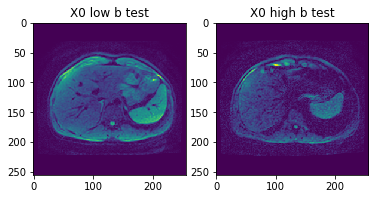

In [9]:
#Slices X1 test
slice_X0_low_test = 12
slice_X0_high_test = 39


plt.figure()

plt.subplot(1,2,1)
plt.title('X0 low b test')
plt.imshow(X_test[0,:,:,slice_X0_low_test,0])
plt.subplot(1,2,2)
plt.title('X0 high b test')
plt.imshow(X_test[0,:,:,slice_X0_high_test,0])

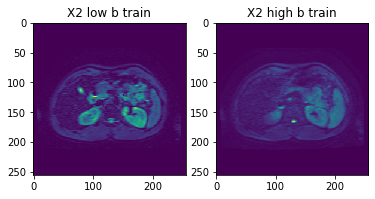

In [10]:
#Slices X2 train
slice_X2_low_train = 12
slice_X2_high_train = 53


plt.figure()

plt.subplot(1,2,1)
plt.title('X2 low b train')
plt.imshow(X_train[2,:,:,slice_X2_low_train,0])
plt.subplot(1,2,2)
plt.title('X2 high b train')
plt.imshow(X_train[2,:,:,slice_X2_high_train,0])

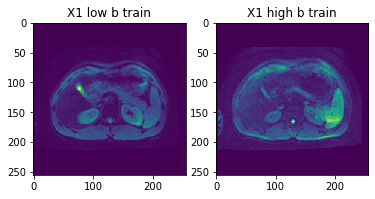

In [11]:
#Slices X1 train
slice_X1_low_train = 16
slice_X1_high_train = 58


plt.figure()

plt.subplot(1,2,1)
plt.title('X1 low b train')
plt.imshow(X_train[1,:,:,slice_X1_low_train,0])
plt.subplot(1,2,2)
plt.title('X1 high b train')
plt.imshow(X_train[1,:,:,slice_X1_high_train,0])

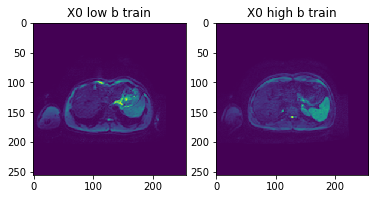

In [12]:
#Slices X0 train
slice_X0_low_train = 30
slice_X0_high_train = 60


plt.figure()

plt.subplot(1,2,1)
plt.title('X0 low b train')
plt.imshow(X_train[0,:,:,slice_X0_low_train,0])
plt.subplot(1,2,2)
plt.title('X0 high b train')
plt.imshow(X_train[0,:,:,slice_X0_high_train,0])

# Model development

In [47]:
model_dir = "/ShareData/emmweber/MachineLearning/predict_BH_dicoms/18052022/DWI_BH_low_high_28/"

gen_model = load_model(model_dir)
gen_model.summary()

Model: "model4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 256, 256, 12  378         ['input_1[0][0]']                
                                8, 3)                                                             
                                                                                                  
 activation (Activation)        (None, 256, 256, 12  0           ['conv3d[0][0]']                 
                                8, 3)                                                        

                                                                                                  
 dropout_2 (Dropout)            (None, 32, 32, 16,   0           ['max_pooling3d_2[0][0]']        
                                12)                                                               
                                                                                                  
 conv3d_9 (Conv3D)              (None, 32, 32, 16,   36024       ['dropout_2[0][0]']              
                                24)                                                               
                                                                                                  
 activation_9 (Activation)      (None, 32, 32, 16,   0           ['conv3d_9[0][0]']               
                                24)                                                               
                                                                                                  
 conv3d_10

                                12)                               'activation_18[0][0]']          
                                                                                                  
 conv3d_transpose_5 (Conv3DTran  (None, 64, 64, 32,   18012      ['add_6[0][0]']                  
 spose)                         12)                                                               
                                                                                                  
 activation_20 (Activation)     (None, 64, 64, 32,   0           ['conv3d_transpose_5[0][0]']     
                                12)                                                               
                                                                                                  
 dropout_5 (Dropout)            (None, 64, 64, 32,   0           ['activation_20[0][0]']          
                                12)                                                               
          

In [14]:
# build the Discriminator ----------------------------------------------------------------

# extraction of encoder -------------
model = Model(inputs = gen_model.layers[0].input, outputs = gen_model.get_layer('activation_9').output)#14').output)#gen_model.layers[44].output)

# add layers ----------------------------------------------------------
x=Flatten()(model.output)
#x=tf.keras.layers.GlobalAveragePooling3D()(model.output)

x=Dropout(0.5,name='dropout_init_new')(x)

x=Dense(5,activation='relu',
       kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed),
        bias_initializer=tf.keras.initializers.Zeros())(x)

x=Dense(1,activation='sigmoid')(x)



disc_model = Model(inputs = gen_model.layers[0].input, outputs = x)

In [15]:
disc_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 256, 256, 12  378         ['input_1[0][0]']                
                                8, 3)                                                             
                                                                                                  
 activation (Activation)        (None, 256, 256, 12  0           ['conv3d[0][0]']                 
                                8, 3)                                                       

                                                                                                  
 dropout_2 (Dropout)            (None, 32, 32, 16,   0           ['max_pooling3d_2[0][0]']        
                                12)                                                               
                                                                                                  
 conv3d_9 (Conv3D)              (None, 32, 32, 16,   36024       ['dropout_2[0][0]']              
                                24)                                                               
                                                                                                  
 activation_9 (Activation)      (None, 32, 32, 16,   0           ['conv3d_9[0][0]']               
                                24)                                                               
                                                                                                  
 flatten (

In [48]:
# Build GAN

#UNet=create_generator_discriminator(X_train=X_train,model='discriminator',
                                    #seed=seed,
                                    #start_neurons=10)
gan_input=Input(X_train.shape[1:])
fake_image=gen_model(gan_input)
gan_output=disc_model(fake_image)

gan=Model(gan_input,gan_output)
gan.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 128, 1  0         
                             )]                                  
                                                                 
 model4 (Functional)         (None, 256, 256, 128, 1)  585685    
                                                                 
 model_3 (Functional)        (None, 1)                 2061053   
                                                                 
Total params: 2,646,738
Trainable params: 2,646,738
Non-trainable params: 0
_________________________________________________________________


# Check Memory usage

In [17]:
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [18]:
model_memory = keras_model_memory_usage_in_bytes(gan,batch_size=1)

In [19]:
import nvidia_smi

nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)
print("Model exceeding memory:",info.free-model_memory)
nvidia_smi.nvmlShutdown()

Total memory: 25757220864
Free memory: 1610416128
Used memory: 24146804736
Model exceeding memory: -1533203150


# Run the model training

In [38]:
path_dir_trained_UNet = "/ShareData/emmweber/MachineLearning/predict_BH_dicoms/18052022/DWI_BH_low_high_28/"
learning_rates=[1e-4, 2e-4, 5.5e-5] #1e-4, 2e-4, 1e-3]


for i in np.arange(len(learning_rates)):
    number=i
    model_path=output_dir+'DWI_BH_low_high'+str(number)
    wandb.init(
                    project="DWI_BH_low_high_GAN_"+output_dir[:-1],
                    # Set entity to specify your username or team name
                    config={
                      #"neuron_size" : 2,
                      "dropout": 0.5,
                      "learning_rate":learning_rates[i],
                      "loss": "mae",
                      "monitor":"val_loss",
                      "metric":"mse",
                      "epoch": 200,
                      "batch_size": 1,
                      "gen_model":model_dir
                      #"validation_split": 0.2,               
                       #"kernel_size": 3,
                       # "stride": strides[stride],
                       # "maxpool": 2
                    })
    
    config = wandb.config
    wandb.run.name = str(number)

    data_train_batch = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(config.batch_size)
    data_test_batch=tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(config.batch_size)
    

    
    # distribute Sstrategy over multiple GPUs
    with strategy.scope():
        gen_model=create_gen_model(path_dir_trained_UNet)
        disc_model,disc_opt=create_disc_model(gen_model,learning_rate=learning_rates[i])
        #disc_model.trainable=True
    
    
    


    # Build GAN
    # distribute Sstrategy over multiple GPUs
    epoch=config.epoch
    learning_rate=learning_rates[i]
    with strategy.scope():
        # freeze weights
        disc_model.trainable=False
        gan, gan_opt = create_GAN_model(disc_model=disc_model,
                                        gen_model=gen_model,
                                        epoch=epoch,
                                        learning_rate)
    
        

    train_gan_model(data_train_batch,
                    data_test_batch,
                    gen_model,
                    disc_model,
                    gan,
                    config,i)

Widget Javascript not detected.  It may not be installed or enabled properly.


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [16]:

7180648448-46795456512
    

-39614808064

In [30]:
23397728256-46795456512
    


-23397728256

In [ ]:
len(data_test_batch)

In [ ]:
gan.compile(loss={'generator' : "mse", 'discriminator' : 'binary_crossentropy'}, loss_weights=[1,0.2],optimizer=gan_opt)


In [ ]:
gan.summary()

In [ ]:
disc_model.summary()

In [ ]:
import training_testing as tt

#Slices X1 test
slice_X0_low_test = 12
slice_X0_high_test = 39

#Slices X1 test
slice_X1_low_test = 12
slice_X1_high_test = 34

#Slices X2 test
slice_X2_low_test = 12
slice_X2_high_test = 34


#Slices X0 train
slice_X0_low_train = 7
slice_X0_high_train = 35

#Slices X1 train
slice_X1_low_train = 16
slice_X1_high_train = 58


#Slices X2 train
slice_X2_low_train = 12
slice_X2_high_train = 53

def visualize_result(model_dir, X_train, X_test, batch_size,
                     slice_X0_low_train,slice_X0_high_train,
                    slice_X1_low_train,slice_X1_high_train,
                    slice_X2_low_train, slice_X2_high_train,
                    slice_X0_low_test,slice_X0_high_test,
                    slice_X1_low_test,slice_X1_high_test,
                    slice_X2_low_test,slice_X2_high_test):    
    
    tf.keras.backend.clear_session()
    
    evalmodel=tt.EvaluateModel(model_dir)
    Y_predict_train = evalmodel.predict_data(X_train,batch_size=batch_size)
    Y_predict_test = evalmodel.predict_data(X_test,batch_size=batch_size)

    #slice_select=10
    
    # low b ---------------------------------
    # train
    slice_select=slice_X0_low_train
    Y0_train_low = Y_predict_train[0,:,:,slice_select,0]
    X0_train_low = X_train[0,:,:,slice_select,0]
    
    slice_select=slice_X1_low_train
    Y1_train_low = Y_predict_train[1,:,:,slice_select,0]
    X1_train_low = X_train[1,:,:,slice_select,0]
    
    slice_select=slice_X2_low_train
    Y2_train_low = Y_predict_train[2,:,:,slice_select,0]
    X2_train_low = X_train[2,:,:,slice_select,0]
    
    # test
    slice_select=slice_X0_low_test
    Y0_test_low = Y_predict_test[0,:,:,slice_select,0]
    X0_test_low = X_test[0,:,:,slice_select,0]
    
    slice_select=slice_X1_low_test
    Y1_test_low = Y_predict_test[1,:,:,slice_select,0]
    X1_test_low = X_test[1,:,:,slice_select,0]
    
    slice_select=slice_X2_low_train
    Y2_test_low = Y_predict_train[2,:,:,slice_select,0]
    X2_test_low = X_test[2,:,:,slice_select,0]
    
    
    # high b ---------------------------------------
    # train
    slice_select=slice_X0_high_train
    Y0_train_high = Y_predict_train[0,:,:,slice_select,0]
    X0_train_high = X_train[0,:,:,slice_select,0]
    
    slice_select=slice_X1_high_train
    Y1_train_high = Y_predict_train[1,:,:,slice_select,0]
    X1_train_high = X_train[1,:,:,slice_select,0]
    
    slice_select=slice_X2_high_train
    Y2_train_high = Y_predict_train[2,:,:,slice_select,0]
    X2_train_high = X_train[2,:,:,slice_select,0]
    
    # test
    slice_select=slice_X0_high_test
    Y0_test_high = Y_predict_test[0,:,:,slice_select,0]
    X0_test_high = X_test[0,:,:,slice_select,0]
    
    slice_select=slice_X1_high_test
    Y1_test_high = Y_predict_test[1,:,:,slice_select,0]
    X1_test_high = X_test[1,:,:,slice_select,0]
    
    slice_select=slice_X2_high_test
    Y2_test_high = Y_predict_train[2,:,:,slice_select,0]
    X2_test_high = X_test[2,:,:,slice_select,0]


    
    
    
    
    # image 0 ----------------
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X0_train_low)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y0_train_low)
    plt.title('Predicted')

    plt.savefig(model_dir+'/train_image_low_0.png')
    plt.close()
    
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X0_test_low)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y0_test_low)
    plt.title('Predicted')

    plt.savefig(model_dir+'/test_image_low_0.png')
    plt.close()
    
    
    # image 2 ----------------

    
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X2_train_low)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y2_train_low)
    plt.title('Predicted')

    plt.savefig(model_dir+'/train_image_low_2.png')
    plt.close()
    
    
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X2_train_low)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y2_test_low)
    plt.title('Predicted')

    plt.savefig(model_dir+'/test_image_low_2.png')
    plt.close()
    
    # inage 1 -----------------
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X1_train_low)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y1_train_low)
    plt.title('Predicted')

    plt.savefig(model_dir+'/train_image_low_1.png')
    plt.close()
    
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X1_test_low)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y1_test_low)
    plt.title('Predicted')

    plt.savefig(model_dir+'/test_image_low_1.png')
    plt.close()
    
    
    
    #---- high b -----------------------------------------
    

    
    
    # image 0 ----------------
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X0_train_high)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y0_train_high)
    plt.title('Predicted')

    plt.savefig(model_dir+'/train_image_high_0.png')
    plt.close()
    
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X0_test_high)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y0_test_high)
    plt.title('Predicted')

    plt.savefig(model_dir+'/test_image_high_0.png')
    plt.close()
    
    
    # image 2 ----------------

    
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X2_train_high)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y2_train_high)
    plt.title('Predicted')

    plt.savefig(model_dir+'/train_image_high_2.png')
    plt.close()
    
    
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X2_test_high)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y2_test_high)
    plt.title('Predicted')

    plt.savefig(model_dir+'/test_image_high_2.png')
    plt.close()
    
    # inage 1 -----------------
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X1_train_high)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y1_train_high)
    plt.title('Predicted')

    plt.savefig(model_dir+'/train_image_high_1.png')
    plt.close()
    
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(X1_test_high)
    plt.title('Input')

    plt.subplot(1,2,2)
    plt.imshow(Y1_test_high)
    plt.title('Predicted')

    plt.savefig(model_dir+'/test_image_high_1.png')
    plt.close()
    
    return 



In [ ]:
model_path = output_dir + str(i) +'/gen_best_model'

visualize_result(model_path,X_train, X_test, config.batch_size,
                        slice_X0_low_train, slice_X0_high_train,
                        slice_X1_low_train, slice_X1_high_train,
                        slice_X2_low_train, slice_X2_high_train,
                        slice_X0_low_test, slice_X0_high_test,
                        slice_X1_low_test, slice_X1_high_test,
                        slice_X2_low_test, slice_X2_high_test)